In [1]:
from ctraptools.kymos.detect import Detector
from lumicks import pylake
from n2v.models import N2V

import stepfitter.stepfitter as sf
import ctraptools.kymos.io as kio
import numpy as np
import os

/Users/sc13967/Documents/Programming/Python/ctraptools/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Parameters
path = "/Users/sc13967/Documents/People/Gemma Fisher/Cropped/20231206-141056 Marker 6_kymo5.tif"
channel = 0

In [3]:
# Loading N2V model
model_name = '2024-02-02_Cropped_Keras'
basedir = '/Users/sc13967/Documents/People/Gemma Fisher/N2V_Models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from '2024-02-02_Cropped_Keras.h5'.


In [4]:
# Loading kymograph as image
if os.path.splitext(path)[1] == ".tif":
    image = kio.read_image(path,channel,x_range=None)
elif os.path.splitext(path)[1] == ".h5" or os.path.splitext(path)[1] == ".hdf5":
    file = pylake.File(path)
    kymo = next(iter(file.kymos.values()))
    image = kymo.get_image()[:,:,channel]

rootpath = os.path.dirname(path)+'/'
rootname = os.path.basename(os.path.splitext(path)[0])

In [5]:
# Applying Noise2Void model
pred_image = model.predict(image, axes='YX', n_tiles=(2,1))
pred_image = pred_image - np.min(pred_image[:])

1/1 [==============================] - 0s 269ms/step


 50%|███████████████████████████████████▌                                   | 1/2 [00:00<00:00, 18558.87it/s]

1/1 [==============================] - 0s 151ms/step


100%|██████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.68it/s]


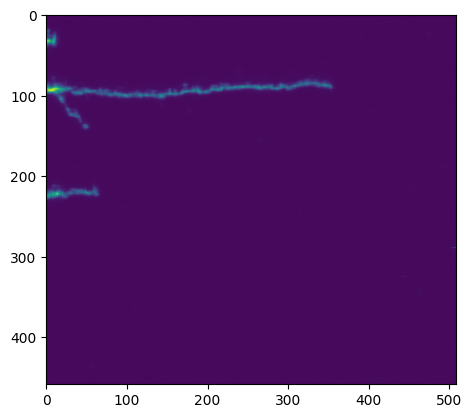

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(pred_image)
plt.show()

In [7]:
# (Optional) Cropping the image in the x-axis
# image = image[:,12:400]

In [7]:
# Initialising Detector
half_t_w = 0
detector = Detector(half_t_w=half_t_w,peak_det_thresh = 0.5, n_max=10, a_lb = 0.5, c_lb=3, c_ub=7, c_def=4, max_dist=15,min_track_length = 10,
                    track_heritage_weight=100,starting_window=10)

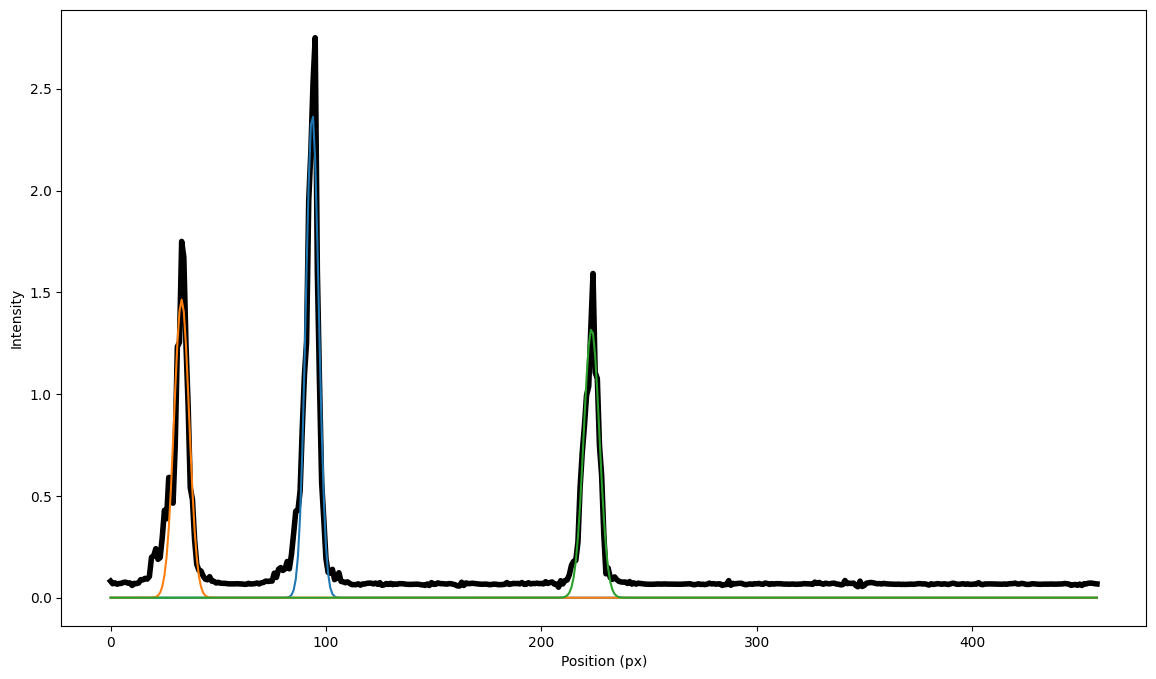

In [9]:
# (Optional) Testing fit parameters
fr = 5
peaks = detector.fit_peaks(pred_image,fr)
kio.plot_gauss_for_frame(peaks,fr,pred_image,half_t_w=half_t_w)

In [10]:
# Detect peaks and track
tracks = detector.detect(pred_image)

100%|█████████████████████████████████████████████████████████████████████| 509/509 [00:01<00:00, 445.26it/s]


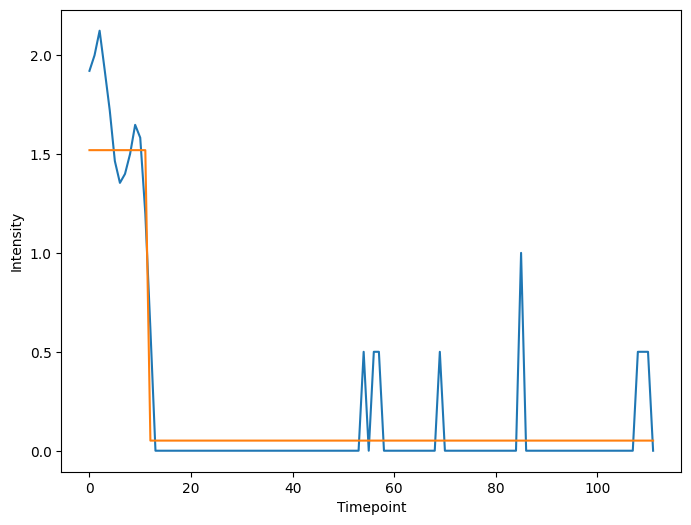

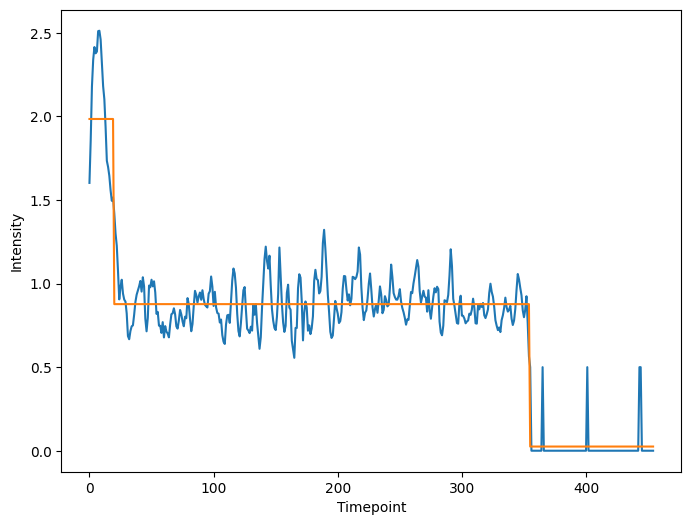

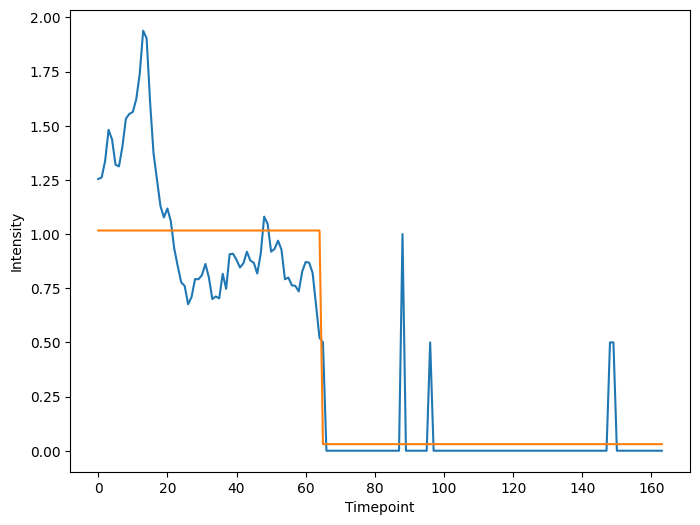

In [21]:
# Measuring intensity
for track in tracks.values():
    track.measure_intensity(image)

# Step fitting (to be added later)
sf.fit_steps(tracks,image,WinSize=50,LMthresh=10)

# Saving files
kio.save_overlay(tracks,image,rootpath+rootname+'_C'+str(channel)+"_overlay")
# kio.write_peak_traces(tracks,rootpath+rootname+'_C'+str(channel)+"_traces")
kio.save_plots(tracks,rootpath+rootname+'_C'+str(channel)+"_traces_raw")
# kio.write_change_points(tracks,rootpath+rootname+'_C'+str(channel)+'_steps')